# Synthetic Single-Modal Data Generation - 1000x1000 Mesh Graph

This notebook generates synthetic single-modal data on a 1000x1000 regular mesh graph (1M nodes) for testing graph-based interpolation methods.

**Key Features:**
- 1000×1000 regular mesh grid (1M nodes)
- Smooth single-modal Gaussian function with noise
- 4-connected mesh graph with unit edge weights
- Consistent node indexing for graph-based methods
- Random sparse sampling for training data
- Same data structure as wind interpolation example

In [25]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import time

# Configuration
GRID_SIZE = 100        # 1000x1000 grid (1M nodes)
NOISE_STD = 0.1         # Standard deviation of noise
TRAINING_RATIO = 0.001   # 1% of nodes for training (10K points)
RANDOM_SEED = 42        # For reproducibility

np.random.seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Grid size: {GRID_SIZE}×{GRID_SIZE} = {GRID_SIZE**2:,} nodes")
print(f"  Training ratio: {TRAINING_RATIO*100:.1f}%")
print(f"  Expected training points: {int(GRID_SIZE**2 * TRAINING_RATIO):,}")
print(f"  Noise std: {NOISE_STD}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Grid size: 100×100 = 10,000 nodes
  Training ratio: 0.1%
  Expected training points: 10
  Noise std: 0.1
  Random seed: 42


In [26]:
# =============================================================================
# MESH GRAPH CONSTRUCTION UTILITIES
# =============================================================================

def grid_index(i, j, n_rows, n_cols):
    """Flatten (i,j) -> node id"""
    return i * n_cols + j

def build_mesh_graph(n_rows, n_cols):
    """
    Build a 4-connected mesh graph efficiently using sparse matrices
    
    Parameters:
    -----------
    n_rows : int
        Number of rows in the grid
    n_cols : int  
        Number of columns in the grid
        
    Returns:
    --------
    A : scipy.sparse.csr_matrix
        Adjacency matrix with unit weights
    """
    n_nodes = n_rows * n_cols
    
    # Pre-allocate for efficiency
    rows = []
    cols = []
    data = []
    
    # 4-connected neighbors: right, left, down, up
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    
    for i in range(n_rows):
        for j in range(n_cols):
            node_id = grid_index(i, j, n_rows, n_cols)
            
            for di, dj in directions:
                ni, nj = i + di, j + dj
                
                # Check bounds
                if 0 <= ni < n_rows and 0 <= nj < n_cols:
                    neighbor_id = grid_index(ni, nj, n_rows, n_cols)
                    
                    rows.append(node_id)
                    cols.append(neighbor_id)
                    data.append(1.0)  # Unit weight
    
    # Create sparse matrix
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    A = A.tocsr()
    
    return A

print("Mesh graph utilities defined")

Mesh graph utilities defined


In [27]:
# =============================================================================
# SYNTHETIC DATA GENERATION
# =============================================================================

def generate_single_modal_function(n_rows, n_cols, noise_std=0.1):
    """
    Generate a smooth single-modal Gaussian function over a 2D grid
    
    Parameters:
    -----------
    n_rows : int
        Number of rows in the grid
    n_cols : int
        Number of columns in the grid  
    noise_std : float
        Standard deviation of additive noise
        
    Returns:
    --------
    y : np.ndarray
        Function values at grid points (flattened)
    coord_mapping : np.ndarray
        (x, y) coordinates for each node
    """
    # Create coordinate grids
    x = np.linspace(-1, 1, n_cols)
    y = np.linspace(-1, 1, n_rows)
    X, Y = np.meshgrid(x, y)
    
    # Single-modal Gaussian function parameters
    center_x, center_y = 0.2, -0.3  # Slightly off-center
    sigma_x, sigma_y = 0.3, 0.4      # Different widths in x and y
    amplitude = 2.0
    
    # Generate smooth single-modal function
    # Gaussian with rotation for more interesting structure
    a = np.cos(np.pi/6)**2 / (2*sigma_x**2) + np.sin(np.pi/6)**2 / (2*sigma_y**2)
    b = -np.sin(2*np.pi/6) / (4*sigma_x**2) + np.sin(2*np.pi/6) / (4*sigma_y**2)
    c = np.sin(np.pi/6)**2 / (2*sigma_x**2) + np.cos(np.pi/6)**2 / (2*sigma_y**2)
    
    dx = X - center_x
    dy = Y - center_y
    
    f_clean = amplitude * np.exp(-(a*dx**2 + 2*b*dx*dy + c*dy**2))
    
    # Add noise
    noise = np.random.normal(0, noise_std, f_clean.shape)
    f_noisy = f_clean + noise
    
    # Flatten to match node indexing: node_id = i * n_cols + j
    y_values = f_noisy.flatten()
    
    # Create coordinate mapping
    coord_mapping = np.zeros((n_rows * n_cols, 2))
    for i in range(n_rows):
        for j in range(n_cols):
            node_id = grid_index(i, j, n_rows, n_cols)
            coord_mapping[node_id, 0] = X[i, j]  # x coordinate
            coord_mapping[node_id, 1] = Y[i, j]  # y coordinate
    
    return y_values, coord_mapping

print("Synthetic data generation function defined")

Synthetic data generation function defined


In [28]:
# =============================================================================
# BUILD MESH GRAPH AND GENERATE DATA
# =============================================================================

print("Building mesh graph and generating synthetic data...")
start_time = time.time()

# Build mesh graph
print("Building 4-connected mesh graph...")
A = build_mesh_graph(GRID_SIZE, GRID_SIZE)
graph_time = time.time() - start_time

print(f"Graph construction completed in {graph_time:.2f} seconds")
print(f"  Adjacency matrix shape: {A.shape}")
print(f"  Number of edges: {A.nnz:,}")
print(f"  Matrix density: {A.nnz / (A.shape[0] * A.shape[1]):.6f}")

# Generate synthetic data
print("\nGenerating single-modal synthetic function...")
data_start = time.time()
y, coord_mapping = generate_single_modal_function(GRID_SIZE, GRID_SIZE, NOISE_STD)
data_time = time.time() - data_start

print(f"Data generation completed in {data_time:.2f} seconds")
print(f"  Function values shape: {y.shape}")
print(f"  Coordinate mapping shape: {coord_mapping.shape}")
print(f"  Function range: [{y.min():.3f}, {y.max():.3f}]")
print(f"  Function mean: {y.mean():.3f}, std: {y.std():.3f}")

# Normalize data (zero mean, unit variance)
y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

print(f"\nNormalization:")
print(f"  Original: mean={y_mean:.3f}, std={y_std:.3f}")
print(f"  Normalized: mean={y_normalized.mean():.6f}, std={y_normalized.std():.6f}")

total_time = time.time() - start_time
print(f"\nTotal time: {total_time:.2f} seconds")

Building mesh graph and generating synthetic data...
Building 4-connected mesh graph...
Graph construction completed in 0.02 seconds
  Adjacency matrix shape: (10000, 10000)
  Number of edges: 39,600
  Matrix density: 0.000396

Generating single-modal synthetic function...
Data generation completed in 0.00 seconds
  Function values shape: (10000,)
  Coordinate mapping shape: (10000, 2)
  Function range: [-0.385, 2.214]
  Function mean: 0.356, std: 0.500

Normalization:
  Original: mean=0.356, std=0.500
  Normalized: mean=-0.000000, std=1.000000

Total time: 0.03 seconds


In [29]:
# =============================================================================
# GENERATE TRAINING DATA AND PREPARE FINAL DATASETS
# =============================================================================

print("Generating training data and preparing final datasets...")

# Create node indices (consistent with graph construction)
n_nodes = GRID_SIZE * GRID_SIZE
X = np.arange(n_nodes)  # Node indices [0, 1, 2, ..., n_nodes-1]

# Use normalized data
y = y_normalized.copy()

# Generate random sparse training locations
n_training = int(n_nodes * TRAINING_RATIO)
X_train = np.random.choice(n_nodes, size=n_training, replace=False)
X_train = np.sort(X_train)  # Sort for consistency
y_train = y[X_train]

print(f"Dataset Statistics:")
print(f"  Total nodes: {n_nodes:,}")
print(f"  Training nodes: {len(X_train):,}")
print(f"  Training coverage: {len(X_train)/n_nodes*100:.3f}%")
print(f"  Data range: [{y.min():.3f}, {y.max():.3f}]")

# Save the processed datasets using same structure as wind example
np.savez(f'synthetic_single_modal_{GRID_SIZE}x{GRID_SIZE}.npz',
         A_data=A.data,
         A_indices=A.indices,
         A_indptr=A.indptr,
         A_shape=A.shape,
         X=X,
         y=y,  # Normalized function values
         y_mean=y_mean,  # Normalization parameters
         y_std=y_std,
         X_train=X_train,
         y_train=y_train,
         coord_mapping=coord_mapping,
         grid_size=GRID_SIZE,
         noise_std=NOISE_STD,
         training_ratio=TRAINING_RATIO,
         random_seed=RANDOM_SEED)

print(f"\n✅ All datasets saved to 'synthetic_single_modal_{GRID_SIZE}x{GRID_SIZE}.npz'")
print(f"✅ Grid size: {GRID_SIZE}×{GRID_SIZE} = {n_nodes:,} nodes")
print(f"✅ Training points: {len(X_train):,}")
print(f"✅ Data normalized: mean=0, std=1")
print(f"✅ Use scipy.sparse.csr_matrix((data, indices, indptr), shape) to reconstruct A")

Generating training data and preparing final datasets...
Dataset Statistics:
  Total nodes: 10,000
  Training nodes: 10
  Training coverage: 0.100%
  Data range: [-1.480, 3.715]

✅ All datasets saved to 'synthetic_single_modal_100x100.npz'
✅ Grid size: 100×100 = 10,000 nodes
✅ Training points: 10
✅ Data normalized: mean=0, std=1
✅ Use scipy.sparse.csr_matrix((data, indices, indptr), shape) to reconstruct A


Creating visualizations of the synthetic dataset...


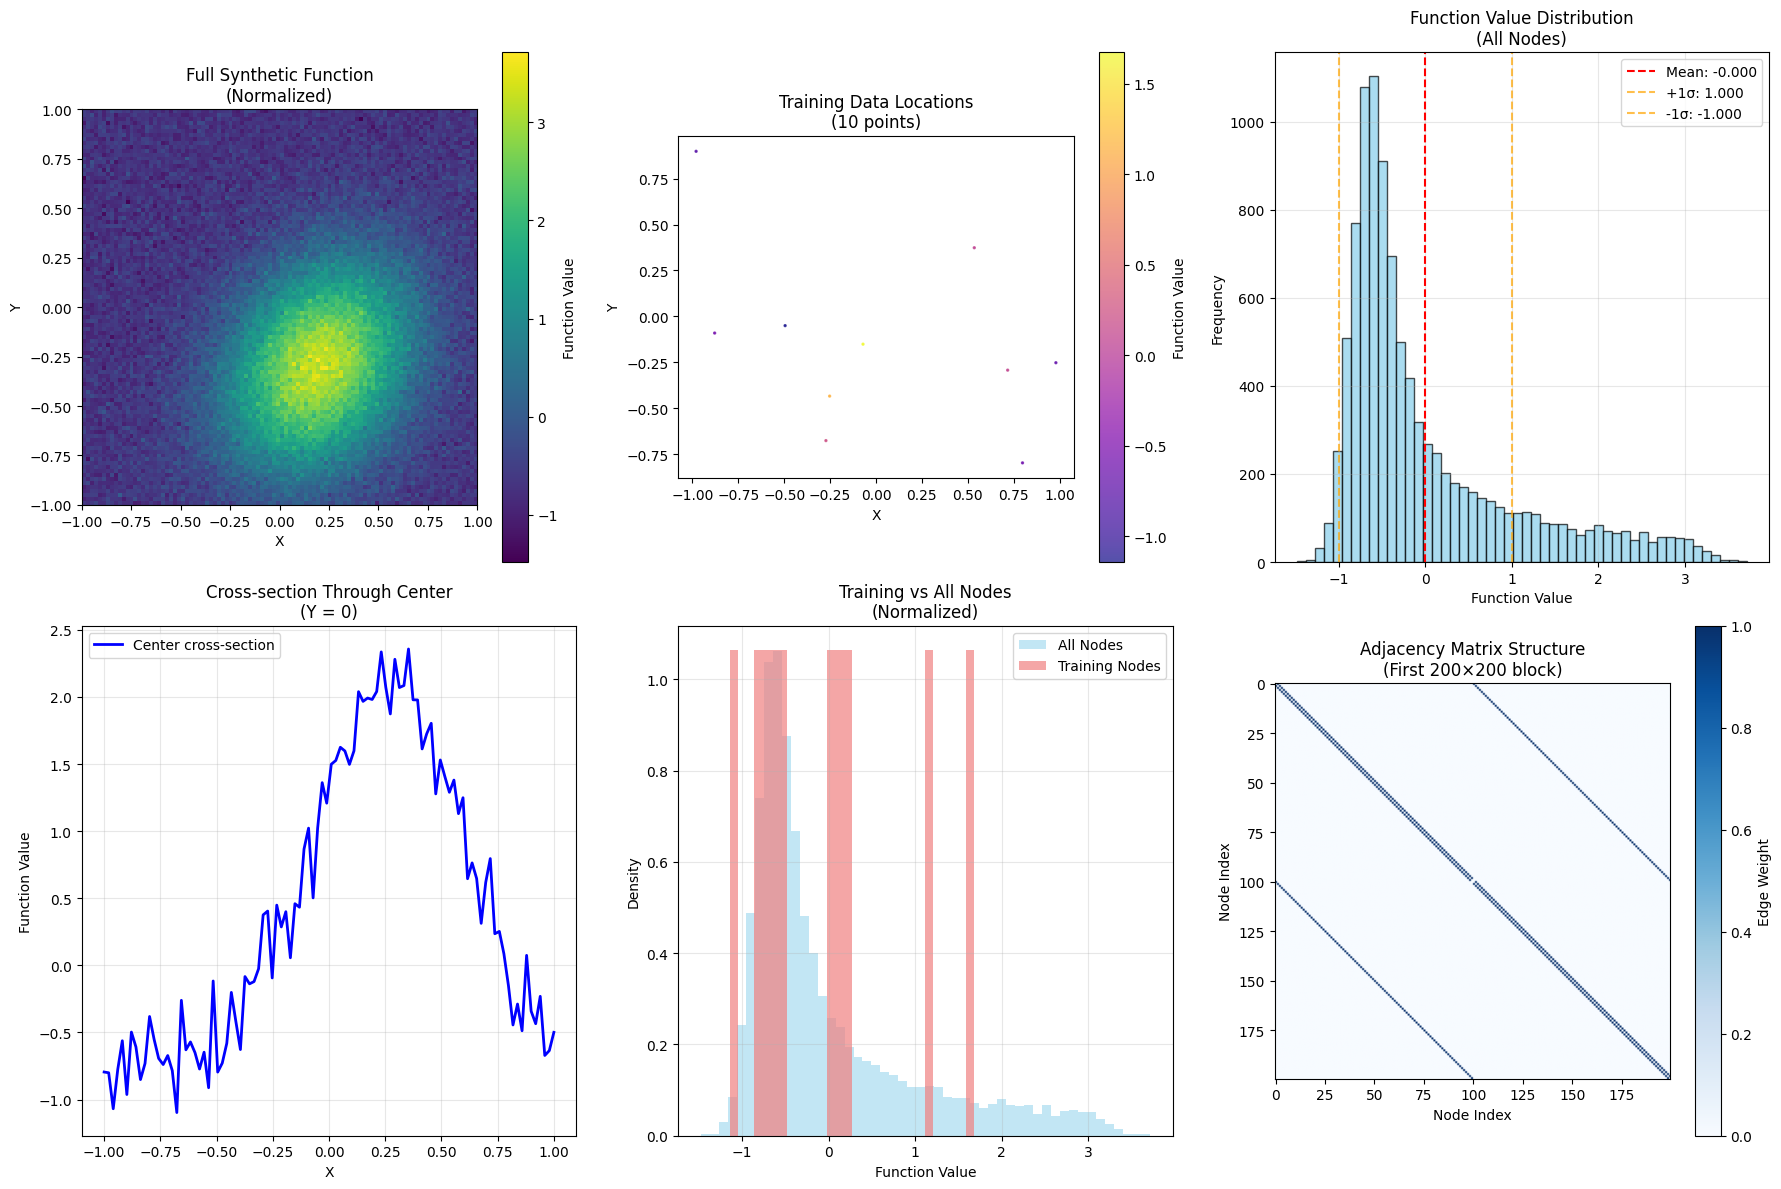


SYNTHETIC DATASET STATISTICS
Function Statistics:
  Total nodes: 10,000
  Mean: -0.000000
  Std: 1.000000
  Min: -1.480
  Max: 3.715
  Median: -0.406

Training Data:
  Training nodes: 10
  Coverage: 0.100%
  Training mean: -0.055823
  Training std: 0.853719

Graph Statistics:
  Adjacency matrix shape: (10000, 10000)
  Number of edges: 39,600
  Matrix density: 0.000396
  Average degree: 3.96

Data Consistency Checks:
  X and y same length: True
  All X_train in bounds: True
  No NaN in y: True
  Coordinate mapping complete: True


In [30]:
# =============================================================================
# VISUALIZE SYNTHETIC DATASET
# =============================================================================

print("Creating visualizations of the synthetic dataset...")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Full function visualization (2D heatmap)
y_2d = y.reshape((GRID_SIZE, GRID_SIZE))
x_coords = np.linspace(-1, 1, GRID_SIZE)
y_coords = np.linspace(-1, 1, GRID_SIZE)

im1 = axes[0, 0].imshow(y_2d, extent=[-1, 1, -1, 1], cmap='viridis', 
                       aspect='equal', origin='lower')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Full Synthetic Function\n(Normalized)')
plt.colorbar(im1, ax=axes[0, 0], label='Function Value')

# 2. Training data locations
train_coords = coord_mapping[X_train]
scatter = axes[0, 1].scatter(train_coords[:, 0], train_coords[:, 1], 
                            c=y_train, cmap='plasma', s=2, alpha=0.7)
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_title(f'Training Data Locations\n({len(X_train):,} points)')
axes[0, 1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[0, 1], label='Function Value')

# 3. Function value distribution
axes[0, 2].hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 2].set_xlabel('Function Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Function Value Distribution\n(All Nodes)')
axes[0, 2].grid(True, alpha=0.3)

# Add statistics
mean_val = np.mean(y)
std_val = np.std(y)
axes[0, 2].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
axes[0, 2].axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.7, label=f'+1σ: {mean_val + std_val:.3f}')
axes[0, 2].axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.7, label=f'-1σ: {mean_val - std_val:.3f}')
axes[0, 2].legend()

# 4. Cross-section through the center
center_row = GRID_SIZE // 2
cross_section = y_2d[center_row, :]
axes[1, 0].plot(x_coords, cross_section, 'b-', linewidth=2, label='Center cross-section')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Function Value')
axes[1, 0].set_title('Cross-section Through Center\n(Y = 0)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 5. Training vs full data comparison
axes[1, 1].hist(y, bins=50, alpha=0.5, color='skyblue', label='All Nodes', density=True)
axes[1, 1].hist(y_train, bins=30, alpha=0.7, color='lightcoral', label='Training Nodes', density=True)
axes[1, 1].set_xlabel('Function Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Training vs All Nodes\n(Normalized)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Adjacency matrix structure (small sample)
sample_size = 200
A_sample = A[:sample_size, :sample_size].toarray()
im6 = axes[1, 2].imshow(A_sample, cmap='Blues', aspect='equal')
axes[1, 2].set_xlabel('Node Index')
axes[1, 2].set_ylabel('Node Index')
axes[1, 2].set_title(f'Adjacency Matrix Structure\n(First {sample_size}×{sample_size} block)')
plt.colorbar(im6, ax=axes[1, 2], label='Edge Weight')

plt.tight_layout()
plt.show()

# Print dataset statistics
print(f"\n" + "="*60)
print("SYNTHETIC DATASET STATISTICS")
print("="*60)
print(f"Function Statistics:")
print(f"  Total nodes: {len(y):,}")
print(f"  Mean: {np.mean(y):.6f}")
print(f"  Std: {np.std(y):.6f}")
print(f"  Min: {np.min(y):.3f}")
print(f"  Max: {np.max(y):.3f}")
print(f"  Median: {np.median(y):.3f}")

print(f"\nTraining Data:")
print(f"  Training nodes: {len(X_train):,}")
print(f"  Coverage: {len(X_train)/len(y)*100:.3f}%")
print(f"  Training mean: {np.mean(y_train):.6f}")
print(f"  Training std: {np.std(y_train):.6f}")

print(f"\nGraph Statistics:")
print(f"  Adjacency matrix shape: {A.shape}")
print(f"  Number of edges: {A.nnz:,}")
print(f"  Matrix density: {A.nnz / (A.shape[0] * A.shape[1]):.6f}")
print(f"  Average degree: {A.nnz / A.shape[0]:.2f}")

print(f"\nData Consistency Checks:")
print(f"  X and y same length: {len(X) == len(y)}")
print(f"  All X_train in bounds: {np.all(X_train < len(y))}")
print(f"  No NaN in y: {not np.any(np.isnan(y))}")
print(f"  Coordinate mapping complete: {len(coord_mapping) == len(y)}")